

# Generative Adversarial Nets
## SubML meeting
## Mon Jun 13

#### Ben Sanchez Lengeling


# Intuitive Idea:
## Let's train two models to compete against each other

We build two neural networks $D$ and $G$, and have them play an adversarial cat-and-mouse game: 

$G$ is a generator and attempts to counterfeit samples from $p_{data}$.

$D$ is a decider that tries to not get fooled. 

We train them simultaneously, so that they both improve by competing with each other.

At convergence, we hope that $G$ has learned to sample exactly from $p_{data}$, at which point $D$ is random guessing.


# Generative vs Discriminative models

* ### X as an observed random variable
* ### Y as a target random variable
* ## Discriminative: $P(Y|X)$
* ## Generative: $P(X,Y)$

# Examples

* cat faces
* anime faces
* faces
* bedrooms
* churches
* typographies
* flowers
* album covers

## 256 randomly generated 32x32 cat images

![](images/cat_faces.jpg)

![](images/flowers.jpg)

# 1D  Demo

Training a generative adversarial network to sample from a Gaussian distribution. 

This is a toy problem, takes < 3 minutes to run on a modest 1.2GHz CPU.


Credit: http://evjang.com/articles/genadv1

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from scipy.stats import norm
from talk import *

%matplotlib inline
awesome_settings()

/Users/beangoben/.local/lib/python3.5/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


## Target distribution $p_{data}$

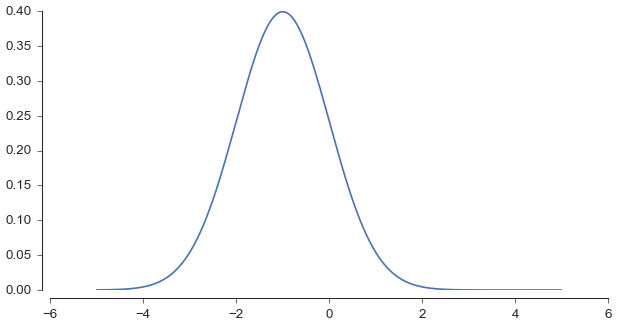

In [2]:
mu,sigma=-1,1
xs=np.linspace(-5,5,1000)
plt.plot(xs, norm.pdf(xs,loc=mu,scale=sigma))
sns.despine(offset=10,trim=True)
plt.show()

# Model setup

* Network $G(z)$ (generator), takes as input a single sample $z$ of a noise distribution $Z \sim Unif(0,1)$ and and generates fake data $x^\prime$
* Network $D(x)$ (descriminator), outputs a likelihood of the input belonging to $p_{data}$
* Each network has 3-layer perceptrons, each with a 11 hidden units

## Two-player Optimization problem :

$$
\min_{G} \max_{D} V(D,G)= \mathbb{E}_{x\sim p_{data}}[log \;D(x)] + \mathbb{E}_{z\sim p_z(z)}[log\;( 1- D(G(z)))]
$$

* $p_z(z)$ prior noise 
* We train $D$ to maximize the probability of assigning the
correct label to both training examples and samples from $G$.
* We train $G$ to maximize $D$ making a mistake $log(1-D(G(z))$

* Optimal when $D$ cannot distinguish from $p_g$ and $p_{data}$, that is $D(x)=0.5$

In [4]:
# MLP - used for D_pre, D1, D2, G networks
TRAIN_ITERS=10000
M=200 # minibatch size
def mlp(input, output_dim):
    # construct learnable parameters within local scope
    w1=tf.get_variable("w0", [input.get_shape()[1], 6], initializer=tf.random_normal_initializer())
    b1=tf.get_variable("b0", [6], initializer=tf.constant_initializer(0.0))
    w2=tf.get_variable("w1", [6, 5], initializer=tf.random_normal_initializer())
    b2=tf.get_variable("b1", [5], initializer=tf.constant_initializer(0.0))
    w3=tf.get_variable("w2", [5,output_dim], initializer=tf.random_normal_initializer())
    b3=tf.get_variable("b2", [output_dim], initializer=tf.constant_initializer(0.0))
    # nn operators
    fc1=tf.nn.tanh(tf.matmul(input,w1)+b1)
    fc2=tf.nn.tanh(tf.matmul(fc1,w2)+b2)
    fc3=tf.nn.tanh(tf.matmul(fc2,w3)+b3)
    return fc3, [w1,b1,w2,b2,w3,b3]

## Optmizer

In [5]:
def momentum_optimizer(loss,var_list):
    batch = tf.Variable(0)
    learning_rate = tf.train.exponential_decay(
        0.001,                # Base learning rate.
        batch,  # Current index into the dataset.
        TRAIN_ITERS // 4,          # Decay step - this decays 4 times throughout training process.
        0.95,                # Decay rate.
        staircase=True)
    optimizer=tf.train.MomentumOptimizer(learning_rate,0.6).minimize(loss,global_step=batch,var_list=var_list)
    return optimizer

# Pre-train

If decider is reasonably accurate to start, there is much faster convergence.

In [6]:
with tf.variable_scope("D_pre"):
    input_node=tf.placeholder(tf.float32, shape=(M,1))
    train_labels=tf.placeholder(tf.float32,shape=(M,1))
    D,theta=mlp(input_node,1)
    loss=tf.reduce_mean(tf.square(D-train_labels))
optimizer=momentum_optimizer(loss,None)
sess=tf.InteractiveSession()
tf.initialize_all_variables().run()

In [50]:
# plot decision surface
def plot_d0(D,input_node):
    f,ax=plt.subplots(1)
    # p_data
    xs=np.linspace(-5,5,1000)
    ax.plot(xs, norm.pdf(xs,loc=mu,scale=sigma), label='p_data')
    #ax.plot(xs, norm.pdf(xs,loc=mu,scale=sigma), label='p_data')

    # decision boundary
    r=1000 # resolution (number of points)
    xs=np.linspace(-5,5,r)
    ds=np.zeros((r,1)) # decision surface
    # process multiple points in parallel in a minibatch
    for i in range(int(r/M)):
        x=np.reshape(xs[M*i:M*(i+1)],(M,1))
        ds[M*i:M*(i+1)]=sess.run(D,{input_node: x})

    ax.plot(xs, ds, label='decision boundary')
    ax.set_ylim(0,1.1)
    plt.legend()

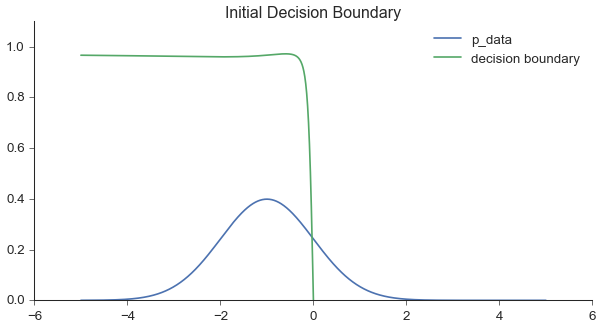

In [51]:
plot_d0(D,input_node)
plt.title('Initial Decision Boundary')
sns.despine()
plt.show()

## Warm-up runs

In [15]:
lh=np.zeros(1000)
for i in range(1000):
    # uniform sampling
    d=(np.random.random(M)-0.5) * 10.0 
    labels=norm.pdf(d,loc=mu,scale=sigma)
    lh[i],_=sess.run([loss,optimizer], {input_node: np.reshape(d,(M,1)), train_labels: np.reshape(labels,(M,1))})

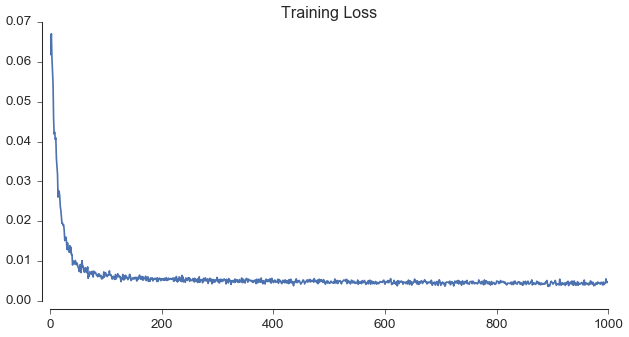

In [17]:
# training loss
plt.plot(lh)
plt.title('Training Loss')
sns.despine(offset=10,trim=True)
plt.show()

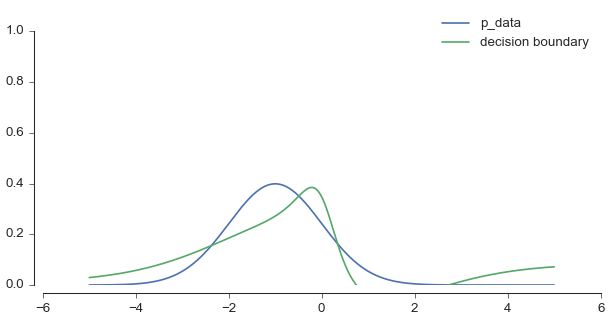

In [18]:
plot_d0(D,input_node)
sns.despine(offset=10,trim=True)
plt.show()

## Wrap-up

In [19]:
# copy the learned weights over into a tmp array
weightsD=sess.run(theta)
# close the pre-training session
sess.close()

# Now for real

## first we build the network

In [21]:
with tf.variable_scope("G"):
    z_node=tf.placeholder(tf.float32, shape=(M,1)) # M uniform01 floats
    G,theta_g=mlp(z_node,1) # generate normal transformation of Z
    G=tf.mul(5.0,G) # scale up by 5 to match range
with tf.variable_scope("D") as scope:
    # D(x)
    x_node=tf.placeholder(tf.float32, shape=(M,1)) # input M normally distributed floats
    fc,theta_d=mlp(x_node,1) # output likelihood of being normally distributed
    D1=tf.maximum(tf.minimum(fc,.99), 0.01) # clamp as a probability
    # make a copy of D that uses the same variables, but takes in G as input
    scope.reuse_variables()
    fc,theta_d=mlp(G,1)
    D2=tf.maximum(tf.minimum(fc,.99), 0.01)
obj_d=tf.reduce_mean(tf.log(D1)+tf.log(1-D2))
obj_g=tf.reduce_mean(tf.log(D2))

# set up optimizer for G,D
opt_d=momentum_optimizer(1-obj_d, theta_d)
opt_g=momentum_optimizer(1-obj_g, theta_g) # maximize log(D(G(z)))

### Copy weights from pre-training over to new D network

In [22]:
sess=tf.InteractiveSession()
tf.initialize_all_variables().run()
for i,v in enumerate(theta_d):
    sess.run(v.assign(weightsD[i]))

In [42]:
def plot_fig(astr):

    # plots pg, pdata, decision boundary 
    f,ax=plt.subplots(1)
    plt.title(astr)

    # p_data
    xs=np.linspace(-5,5,1000)
    ax.plot(xs, norm.pdf(xs,loc=mu,scale=sigma), label='p_data')

    # decision boundary
    r=5000 # resolution (number of points)
    xs=np.linspace(-5,5,r)
    ds=np.zeros((r,1)) # decision surface
    # process multiple points in parallel in same minibatch
    for i in range(int(r/M)):
        x=np.reshape(xs[M*i:M*(i+1)],(M,1))
        ds[M*i:M*(i+1)]=sess.run(D1,{x_node: x})

    ax.plot(xs, ds, label='decision boundary')

    # distribution of inverse-mapped points
    zs=np.linspace(-5,5,r)
    gs=np.zeros((r,1)) # generator function
    for i in range(int(r/M)):
        z=np.reshape(zs[M*i:M*(i+1)],(M,1))
        gs[M*i:M*(i+1)]=sess.run(G,{z_node: z})
    histc, edges = np.histogram(gs, bins = 10)
    ax.plot(np.linspace(-5,5,10), histc/float(r),lw=4, label='p_gen')
    
    x=np.linspace(-5,5,10)
    ax.plot(x, np.ones(len(x))*0.5,'--', label='0.5')

    # ylim, legend
    ax.set_ylim(0,1.1)
    plt.legend()

# Initial conditions


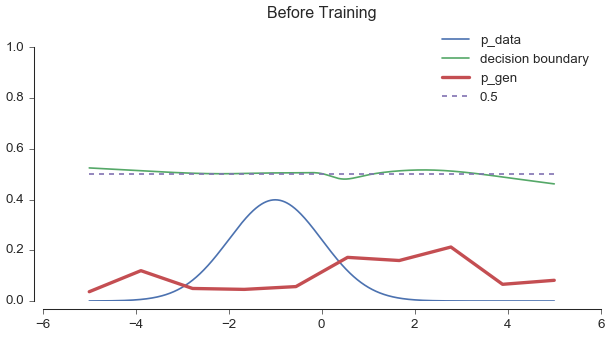

In [43]:
plot_fig('Before Training')
sns.despine(offset=10,trim=True)
plt.show()

# Algorithm 1 of Goodfellow et al 2014
Stochastic gradient descent with mini-batches, maxmin opt

![](images/Algo1.png)


## in the code ..

In [48]:
k=3
histd, histg= np.zeros(TRAIN_ITERS), np.zeros(TRAIN_ITERS)
for i in range(TRAIN_ITERS):
    for j in range(k):
        # sampled m-batch from p_data
        x= np.random.normal(mu,sigma,M) 
        x.sort()
        # sample m-batch from noise
        z= np.linspace(-5.0,5.0,M)+np.random.random(M)*0.01  
        # update D
        histd[i],_=sess.run([obj_d,opt_d], {x_node: np.reshape(x,(M,1)), z_node: np.reshape(z,(M,1))})
    # sample noise prior
    z= np.linspace(-5.0,5.0,M)+np.random.random(M)*0.01 
    # update G
    histg[i],_=sess.run([obj_g,opt_g], {z_node: np.reshape(z,(M,1))}) 
    # verbose
    if i % (TRAIN_ITERS//10) == 0:
        print(float(i)/float(TRAIN_ITERS))

0.0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9


# Training results

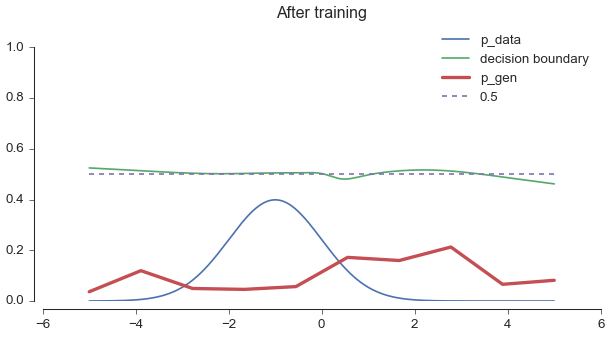

In [45]:
plot_fig('After training')
sns.despine(offset=10,trim=True)
plt.show()

# More into examples

## Laplacian pyramid of GAN's
Each network $G_x$ generates the difference image, when added to the input image, gives a finer-scaled image.

![](images/laplacian_pyramid.png)

## Finer details

![](images/bedroom1.png)

## The illusion of objectness

> The images always looked object-like, but had no actual object.

![](images/predicted16.png)

## Mixing generators

![](images/recursive.png)

## Latent space

### Rotations are linear

![](images/linear_rotation.png)

## Class-conditional generative adversarial network
Pass to the G networks not only an input random noise, but also a one-hot coding of a class label.

![](images/ccgan.png)

# Ideas?

* Data augmentation
* Representation Learning
